In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [2]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Email network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [3]:
from lib.generators.OLP import OLP


generator = OLP(
    network_name='Email_network_Uni_R-V_Spain_Email_network_Uni_R-V_Spain', 
    seed=seed
)

feature_names = generator.feature_names

Loading file...
Network info:

title: Email network (Uni. R-V, Spain, 2003)
description: A network representing the exchange of emails among members of the Rovira i Virgili University in Spain, in 2003. The KONECT version is undirected.
networkDomain: Social
subDomain: Communication
citation: R. Guimera, L. Danon, A. Diaz-Guilera, F. Giralt and A. Arenas, "Self-similar community structure in a network of human interactions." Physical Review E 68, 065103(R) (2003).
sourceUrl: http://deim.urv.cat/~alexandre.arenas/publicacions/pdf/email.pdf

File loaded!
Calculating features...
Features calculated!
Train/test splitting...
Done splitting the data!


In [4]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [5]:
link_prediction_train.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean
0,546,830,0,0.0,0.000375,0.0,0.000090,0.003367,0.0,0.0,0.0,-6.190794e-17,1.327629e-15,-2.498950e-16
1,386,1006,0,0.0,0.000375,0.0,0.000050,0.017677,0.0,0.0,0.0,-1.725237e-17,1.108981e-15,-4.249960e-16
2,148,399,0,0.0,0.000250,0.0,0.000661,0.060606,0.0,0.0,0.0,6.855546e-16,1.294581e-15,-8.367782e-17
3,293,433,0,0.0,0.000250,0.0,0.000884,0.021886,0.0,0.0,0.0,1.509413e-16,1.042822e-15,-1.692326e-17
4,305,990,0,0.0,0.000375,0.0,0.000035,0.008418,0.0,0.0,0.0,-1.642837e-16,1.387783e-15,3.372597e-16


## Step 2
### Link prediction model

In [6]:
model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=seed)
model.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

prob = model.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_test.join(prob)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob
0,914,994,0,0.0,0.000375,0.0,0.000183,0.025253,0.0,0.0,0.0,8.085395e-17,1.213785e-15,-3.578284e-17,0.168438
1,414,1113,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-1.397500e-33,1.327774e-15,0.000000e+00,0.411990
2,568,1017,0,0.0,0.000375,0.0,0.000031,0.006734,0.0,0.0,0.0,1.302127e-16,1.374592e-15,2.666968e-17,0.037365
3,102,877,0,0.0,0.000250,0.0,0.000150,0.015152,0.0,0.0,0.0,7.755434e-17,1.326646e-15,1.621999e-16,0.334066
4,741,838,0,0.0,0.000375,0.0,0.000031,0.003367,0.0,0.0,0.0,-9.259087e-17,1.338023e-15,-3.462671e-18,0.038928


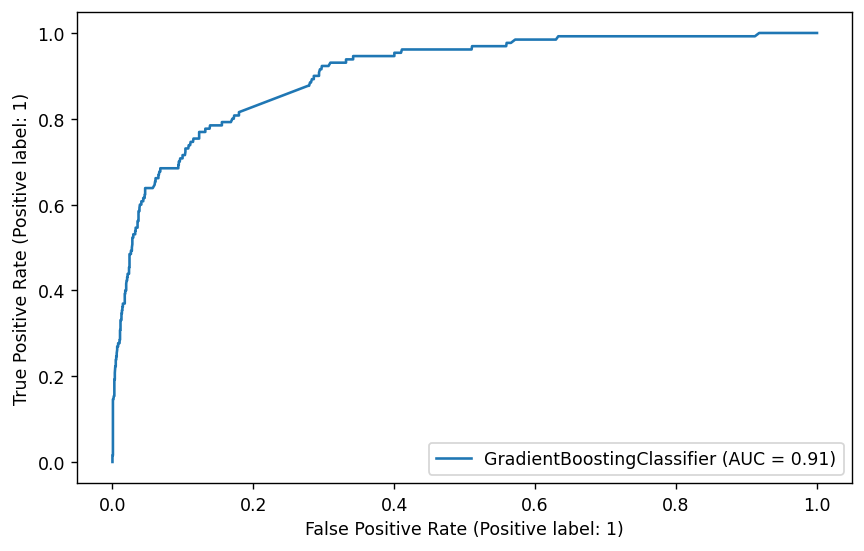

In [7]:
# ROC-AUC for the link prediction model
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model, link_prediction_test[feature_names], link_prediction_test['goal'])  

## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [9]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error
0,914,994,0,0.0,0.000375,0.0,0.000183,0.025253,0.0,0.0,0.0,8.085395e-17,1.213785e-15,-3.578284e-17,0.168438,0.168438
1,414,1113,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-1.397500e-33,1.327774e-15,0.000000e+00,0.411990,0.411990
2,568,1017,0,0.0,0.000375,0.0,0.000031,0.006734,0.0,0.0,0.0,1.302127e-16,1.374592e-15,2.666968e-17,0.037365,0.037365
3,102,877,0,0.0,0.000250,0.0,0.000150,0.015152,0.0,0.0,0.0,7.755434e-17,1.326646e-15,1.621999e-16,0.334066,0.334066
4,741,838,0,0.0,0.000375,0.0,0.000031,0.003367,0.0,0.0,0.0,-9.259087e-17,1.338023e-15,-3.462671e-18,0.038928,0.038928


In [10]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.18846663992080281

In [11]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error,quality_label
0,914,994,0,0.0,0.000375,0.0,0.000183,0.025253,0.0,0.0,0.0,8.085395e-17,1.213785e-15,-3.578284e-17,0.168438,0.168438,1
1,414,1113,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-1.397500e-33,1.327774e-15,0.000000e+00,0.411990,0.411990,0
2,568,1017,0,0.0,0.000375,0.0,0.000031,0.006734,0.0,0.0,0.0,1.302127e-16,1.374592e-15,2.666968e-17,0.037365,0.037365,1
3,102,877,0,0.0,0.000250,0.0,0.000150,0.015152,0.0,0.0,0.0,7.755434e-17,1.326646e-15,1.621999e-16,0.334066,0.334066,0
4,741,838,0,0.0,0.000375,0.0,0.000031,0.003367,0.0,0.0,0.0,-9.259087e-17,1.338023e-15,-3.462671e-18,0.038928,0.038928,1


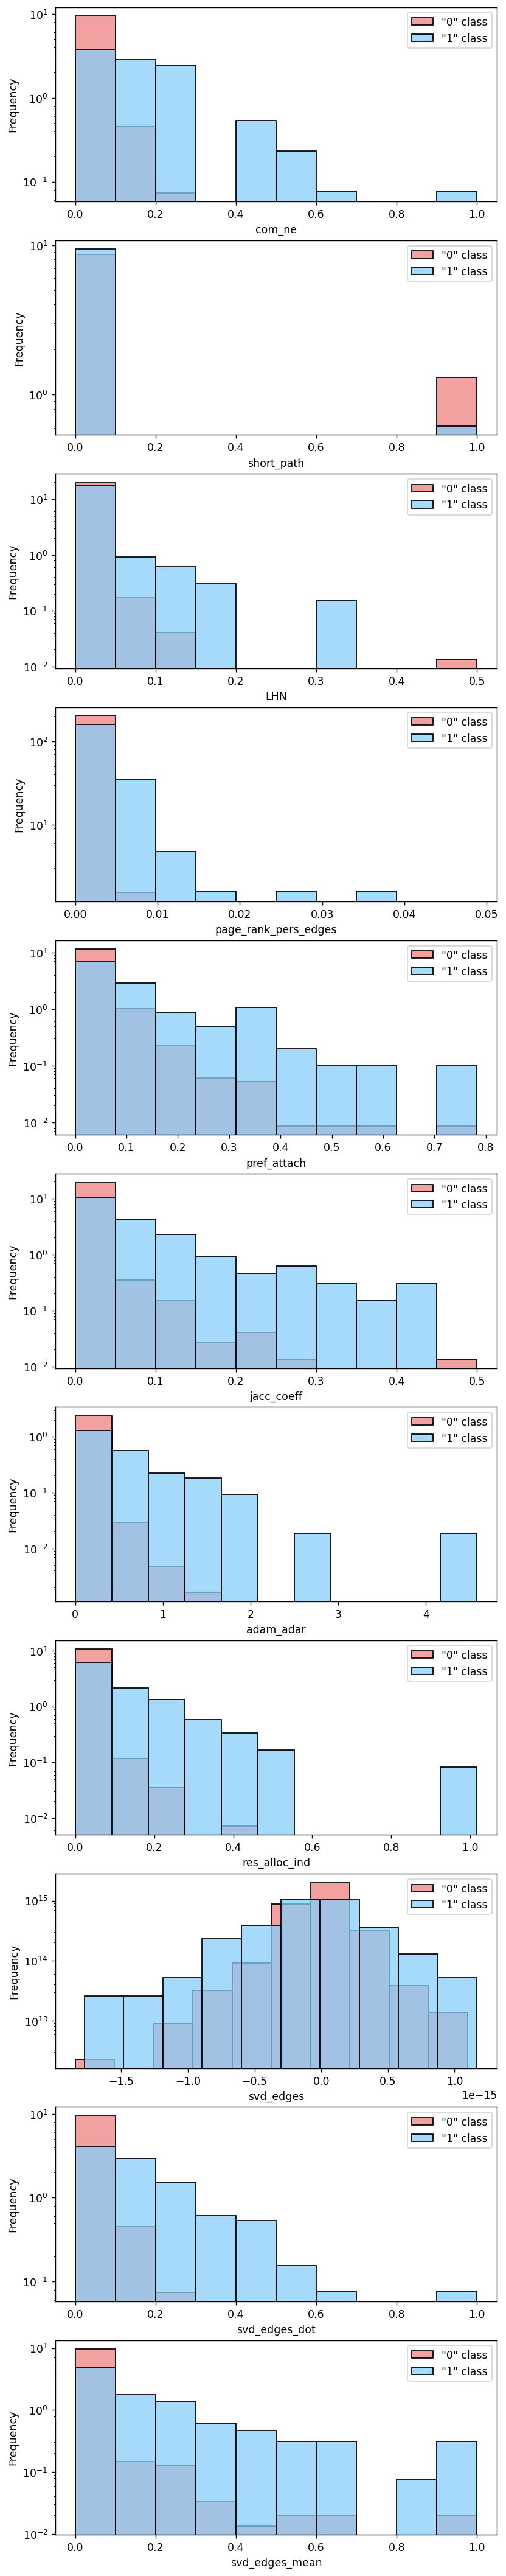

In [8]:
# distribution of features of predictable and unpredictable classes

mpl.rcParams['figure.figsize'] = [7.5, 4*len(feature_names)]

fig, axs = plt.subplots(ncols=1, nrows=len(feature_names))
colors = ['lightcoral', 'lightskyblue']

for i, feature in enumerate(feature_names):
    width = (link_proba[feature].max()-link_proba[feature].min())/10
    for j in [0, 1]:
        data = link_prediction_test[link_prediction_test['goal'] == j]

        sn.histplot(data, x=feature, ax=axs[i], binwidth=width, color=colors[j], stat='frequency', label=f'"{j}" class')
        axs[i].set(xlabel=feature, ylabel='Frequency')
        axs[i].set_yscale("log")
        axs[i].legend()


In [12]:
model_2 = GradientBoostingClassifier(n_estimators=500, max_depth=6, random_state=seed)
model_2.fit(link_proba[feature_names], link_proba['quality_label'])

GradientBoostingClassifier(max_depth=6, n_estimators=500, random_state=59)

In [13]:
# testing the classifier

pred = model_2.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])[:,1]
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

In [14]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.18187840093209573

In [15]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,125,853,0,0.0,0.000250,0.0,0.000063,0.003367,0.0,0.0,0.0,1.465359e-16,1.310765e-15,-1.764314e-16,0.070653,1,0.070653,1
1,301,683,0,0.0,0.000375,0.0,0.000051,0.001684,0.0,0.0,0.0,7.594836e-17,1.350611e-15,5.752031e-17,0.091250,1,0.091250,1
2,271,313,0,0.0,0.000125,0.0,0.000779,0.018519,0.0,0.0,0.0,-3.771668e-17,1.395861e-15,2.086663e-17,0.653643,0,0.653643,0
3,742,909,0,0.0,0.000375,0.0,0.000050,0.030303,0.0,0.0,0.0,1.000329e-16,1.346732e-15,9.537167e-17,0.416086,0,0.416086,0
4,87,140,0,0.0,0.000250,0.0,0.000261,0.053030,0.0,0.0,0.0,-5.903481e-17,1.157737e-15,-3.566396e-17,0.188078,0,0.188078,0


In [16]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     813
0                     806
dtype: int64

In [17]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          857
0                          762
dtype: int64

In [18]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    model_2.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1619.000000
1,Accuracy,0.920939
2,Precision,0.922266
3,Recall,0.920939
4,F1 score,0.920871


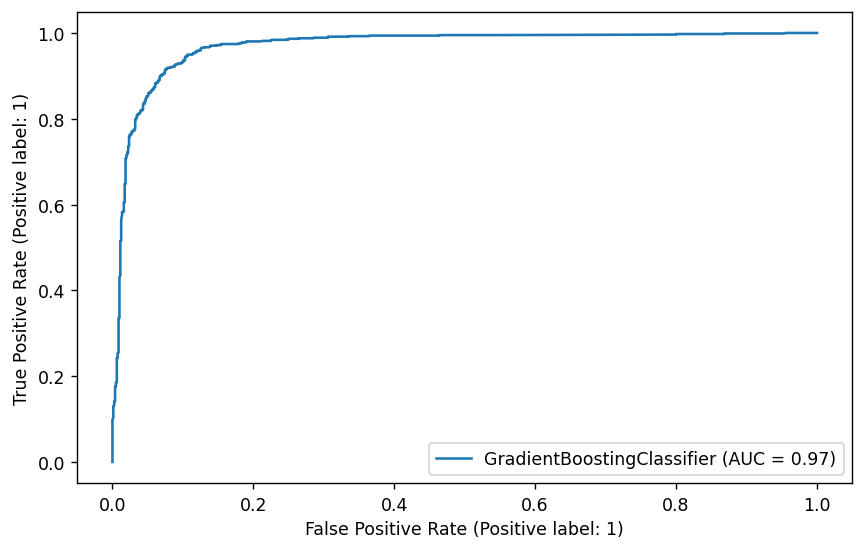

In [19]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])  

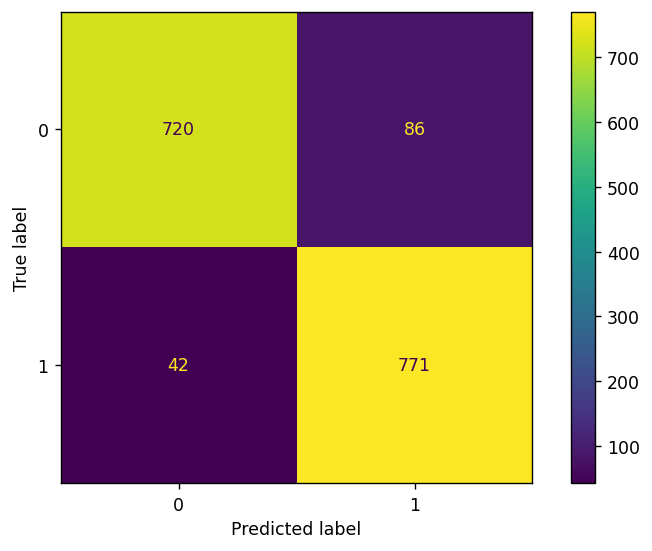

In [20]:
metrics.plot_confusion_matrix(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])

In [21]:
importances_pd = pd.DataFrame()
importances_pd['Reconstruction feature importance'] = pd.Series(model.feature_importances_, index=feature_names)
importances_pd['Classification feature importance'] = pd.Series(model_2.feature_importances_, index=feature_names)
importances_pd['Diff'] = importances_pd.apply(lambda x: math.fabs(x['Reconstruction feature importance'] - x['Classification feature importance']), axis=1)

importances_pd

,Reconstruction feature importance,Classification feature importance,Diff
com_ne,0.000223,0.000426,0.000204
short_path,0.041019,0.192055,0.151036
LHN,0.010188,0.012718,0.002530
page_rank_pers_edges,0.834939,0.471730,0.363208
pref_attach,0.061571,0.210549,0.148978
jacc_coeff,0.002176,0.014849,0.012673
adam_adar,0.005960,0.033837,0.027877
res_alloc_ind,0.007100,0.051536,0.044436
svd_edges,0.000000,0.000000,0.000000
svd_edges_dot,0.000401,0.000393,0.000009


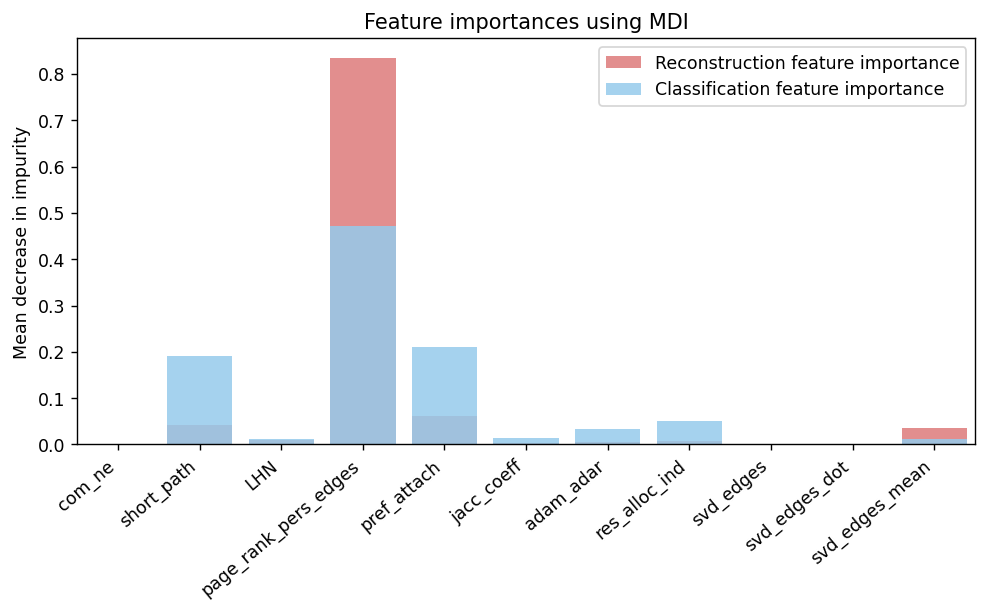

In [22]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

fig, ax = plt.subplots()

sn.barplot(
    data=importances_pd, 
    x=feature_names, 
    y='Reconstruction feature importance', 
    label='Reconstruction feature importance',
    ax=ax, 
    color='lightcoral', 
    alpha=1
)

sn.barplot(
    data=importances_pd, 
    x=feature_names, 
    y='Classification feature importance', 
    label='Classification feature importance', 
    ax=ax, 
    color='lightskyblue', 
    alpha=0.85
)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend()

fig.tight_layout()